# ODE Integrators III: Advanced Topics

## Adaptive Stepsize Control

When we integrate ordinary differential equations (ODEs), the choice of time step $\Delta t$ can influence the accuracy and efficiency of our numerical solutions.
This issue becomes especially important for systems that exhibit rapid changes in time and/or chaotic behavior.
In such cases, tiny differences in initial conditions or time step selection can lead to wildly different outcomes.
This highlights why we must continually monitor and control numerical errors.

**Adaptive step size control** provides a systematic way to handle these challenges.
Instead of using a fixed $\Delta t$, adaptive methods dynamically change the time step based on error estimates at each step.
The critical idea behind adaptive step size control is to balance two competing goals:
* **Accuracy:** Keep truncation (local) errors within a user-specified tolerance.
* **Efficiency:** Avoid making the time step too small, which would waste computational resources.

In practice, we estimate the local error of a proposed step and compare it to a tolerance that combines both absolute and relative components.
If the error is too large, we reduce the step size.
If it is safely below the tolerance, we may increase it.
This approach automatically "zooms in" when the ODE solution changes rapidly and "zooms out" when the solution is smoother.

### Error Estimate

To illustrate one of the simplest ways to estimate errors, consider advancing the solution from $t$ to $t + 2\Delta t$.
There are two ways to do this:
1. Step the ODE system with a single step $\Delta t' = 2\Delta t$.
2. Step the ODE system with two consecutive steps, each step is $\Delta t$.

For a fourth-order method (e.g., classic Runge–Kutta 4), the local truncation errors differ between these two approaches.
Symbolically, the resulting solutions (ignoring higher-order terms) look like:
\begin{align}
\text{One step:}  \quad x(t + 2\Delta t) &= x_1 + (2\Delta t)^5 \phi + \mathcal{O}(\Delta t^6) + \dots \\
\text{Two steps:} \quad x(t + 2\Delta t) &= x_2 +  2\Delta t^5  \phi + \mathcal{O}(\Delta t^6) + \dots
\end{align}
where $\phi$ is some function of $t$ and $x(t)$.
We focus on just the leading $\Delta t^5$ terms and define
\begin{align}
\Delta = x_2 - x_1,
\end{align}
to give an approximate measure of the local truncation error.
If $\Delta$ is "too large," we should reduce $\Delta t$.
If $\Delta$ is "too small," we might be over-resolving the solution and can safely increase $\Delta t$.

### Richardson Extrapolation

An interesting by-product of step doubling is Richardson extrapolation, which can yield a higher-order estimate:
\begin{align}
x(t + 2\Delta t) = x_2 + \frac{\Delta}{15} + \mathcal{O}(\Delta t^6)
\end{align}
While this estimate is more accurate (fifth-order), we have no direct way to estimate or control its truncation error at that higher order.
Therefore, it is not as convenient for adaptive step size selection as one might initially hope.

### Embedded Runge-Kutta Formulas: The Dormand–Prince Method

Although step doubling is an intuitive idea, modern ODE solvers usually rely on embedded Runge–Kutta formulas.
An embedded method computes two solutions of different orders at each step without performing two full sets of time steps.

Dormand–Prince (DP) methods belong to the family of Runge–Kutta integrators.
For many practical problems, DP45 (also called “DOPRI5”) reaches a favorable balance between:
* Accuracy per function evaluation
* Reliability of its built-in error estimate
* Simplicity of implementation

For instance, Dormand–Prince 4(5) computes a fifth-order ($p=5$) approximation and a fourth-order ($p-1=4$) approximation simultaneously using only six function evaluations.
It is popularity in libraries such as MATLAB's `ode45`.

Below is the general structure of a 5th-order Runge–Kutta method:
\begin{align}
k_1 &= \Delta t\,f(x_n, t_n)\\
k_2 &= \Delta t\,f(x_n + a_{21}k_1, t_n + c_2 \Delta t)\\
\cdots\\
k_6 &= \Delta t\,f(x_n + a_{61}k_1 + \cdots + a_{65}k_5, t_n + c_6 \Delta t)\\
x_{n+1} &= x_n + b_1 k_1 + b_2 k_2 + \cdots + b_6 k_6 + \mathcal{O}(\Delta t^6)
\end{align}

Dormand–Prince uses a particular set of coefficients $a_{ij}, b_i, c_i$.
During each step, it also computes a lower-order approximation $x_\text{low}$ using a different set $\widetilde{b}_i$.
The difference $x_\text{high} - x_\text{low}$ is used to estimate the local truncation error.

Below are the coefficients for the DP method:

In [17]:
! pip install jax

/home/codespace/.python/current/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [18]:
import jax
jax.config.update("jax_enable_x64", True)

In [19]:
from jax import numpy as np

In [20]:
a =[
    [],
    [1/5],
    [3/40, 9/40],
    [44/45, -56/15, 32/9],
    [19372/6561, -25360/2187, 64448/6561, -212/729],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84],
]

b_high = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0] # Fifth-order accurate solution estimate
b_low  = [5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40] # Fourth-order accurate solution estimate

c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]

A DP45 step is therefore

In [21]:
def DP45_step(f, x, t, dt):
        # Compute intermediate k1 to k7
    k1 = f(x)
    k2 = f(x + dt*(a[1][0]*k1))
    k3 = f(x + dt*(a[2][0]*k1 + a[2][1]*k2))
    k4 = f(x + dt*(a[3][0]*k1 + a[3][1]*k2 + a[3][2]*k3))
    k5 = f(x + dt*(a[4][0]*k1 + a[4][1]*k2 + a[4][2]*k3 + a[4][3]*k4))
    k6 = f(x + dt*(a[5][0]*k1 + a[5][1]*k2 + a[5][2]*k3 + a[5][3]*k4 + a[5][4]*k5))
    k7 = f(x + dt*(a[6][0]*k1 + a[6][1]*k2 + a[6][2]*k3 + a[6][3]*k4 + a[6][4]*k5 + a[6][5]*k6))

    ks = [k1, k2, k3, k4, k5, k6, k7]

    # Compute high and low order estimates
    x_high = x
    for b, k in zip(b_high, ks):
        x_high += dt * b * k

    x_low  = x 
    for b, k in zip(b_low, ks):
        x_low += dt * b * k

    return x_high, x_low, ks

### Proportional-Integral (PI) Step Size Control

Once we have an embedded Runge-Kutta method like Dormand–Prince in place, the next step is to implement a mechanism to adjust the step size based on the estimated local error.
The PI (Proportional-Integral) controller is a widely-used strategy for this purpose, combining proportional and integral components to achieve stable and efficient step size adjustments.

To decide if the step is "acceptable," we compare the difference $| x_\text{high} - x_\text{low} |$ against a user-defined tolerance.
A common practice is to combine an absolute tolerance (`atol`) for small values of the solution and a relative tolerance (`rtol`) for large ones.
We form:
\begin{align}
\text{tol} = \text{atol} + \text{rtol}\,|x_\text{high}|.
\end{align}

If the difference $|x_\text{high} - x_\text{low}|$ is larger than `tol`, we reject the step and try again with a smaller $\Delta t$.
If it is smaller, we accept the step, move forward in time, and possibly increase $\Delta t$ for the next step.

A widely used formula for updating $\Delta t$ is:
\begin{align}
h_{\text{new}} = h \cdot \min\left(\text{fac}{\text{max}}, \max\left(\text{fac}{\text{min}}, \text{fac} \cdot \left(\frac{\text{tol}}{E}\right)^{\alpha}\right)\right)
\end{align}
where
* $\text{fac}$ is a scaling factor (typically around 0.9) to provide a safety margin;
* $\text{fac}{\text{min}}$ and $\text{fac}{\text{max}}$ set the minimum and maximum allowable step size multipliers to prevent excessive changes; and
* $\alpha$ is an exponent that determines the responsiveness of the step size adjustment.

Here is a simple Python function implementing this logic:

In [22]:
def dt_update(dt, error, tol, fac=0.9, fac_min=0.1, fac_max=4.0, alpha=0.2):
    if error == 0:
        s = fac_max
    else:
        s = fac * (tol / error) ** alpha
    s = min(fac_max, max(fac_min, s))
    dt_new = dt * s
    return dt_new

### Combining Steps and Control

Putting it all together, we implement a basic DP45 integrator with adaptive step sizing.
Notice that we allow the step to be reduced if the local error exceeds the tolerance:

In [23]:
def DP45(f, x, t, T, dt, atol, rtol):

    Ts = [t]
    Xs = [np.array(x)]

    while t < T:
        if t + dt > T:
            dt = T - t  # Adjust step size to end exactly at tf

        # Perform a single Dormand–Prince step
        x_high, x_low, _ = DP45_step(f, x, t, dt)

        # Compute the error estimate
        error = np.linalg.norm(x_high - x_low, ord=np.inf)

        # Compute the tolerance
        tol = atol + rtol * np.linalg.norm(x_high, ord=np.inf)

        # Check if the step is acceptable
        if error <= tol:
            # Accept the step
            t += dt
            x = x_high
            Ts.append(t)
            Xs.append(x)

        # Compute the new step size
        dt = dt_update(dt, error, tol)

    return np.array(Ts), np.array(Xs)

### Example Applications

We can now apply DP45 to integrate ODEs.

Applying to the simple harmonic oscillator, we may specifically ask for the accuracy:

In [24]:
def f_sh(x):
    theta, omega = x
    return np.array([omega, -theta])

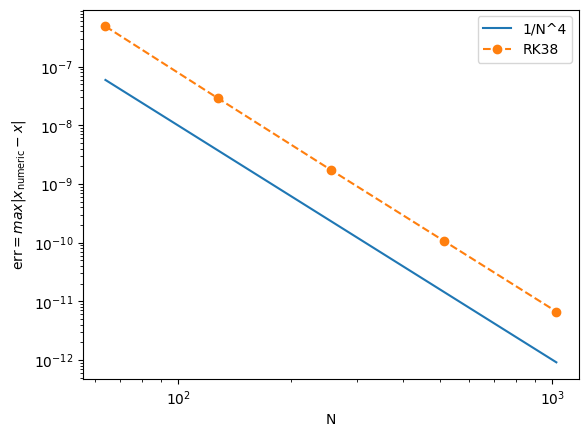

In [25]:
from matplotlib import pyplot as plt

def error_DP45(tol):
    T, X = DP45(f_sh, np.array([0, 0.01]), 0, 10, 0.1, tol, tol)
    Theta  = X[:,0]
    Thetap = 0.01 * np.sin(T)
    return np.max(abs(Theta - Thetap))

N     = np.array([64, 128, 256, 512, 1024])
EDP45 = np.array([error_DP45(tol) for tol in 2.0**(-22-4*np.arange(5))])

plt.loglog(N, 1/N**4,      label='1/N^4')
plt.loglog(N, EDP45, 'o--', label='RK38')
plt.xlabel('N')
plt.ylabel(r'$\text{err} = max|x_\text{numeric} - x|$')
plt.legend()

For non-linear problems, we can also compare different accuracies:

In [26]:
def f_dp(x):
    th1, th2, p1, p2 = x
    
    m  = 1
    l  = 1
    g  = 1

    u1 = m * l * l
    u2 = g / l
    f  = 6 / (u1 * (16 - 9 * np.cos(th1 - th2)**2))

    dth1 = f * (2 * p1 - 3 * np.cos(th1 - th2) * p2)
    dth2 = f * (8 * p2 - 3 * np.cos(th1 - th2) * p1)

    dp1  = - 0.5 * u1 * (  dth1 * dth2 * np.sin(th1 - th2) + 3 * u2 * np.sin(th1))
    dp2  = - 0.5 * u1 * (- dth1 * dth2 * np.sin(th1 - th2) +     u2 * np.sin(th2))

    return np.array([dth1, dth2, dp1, dp2])

Text(0.5, 0, 't')

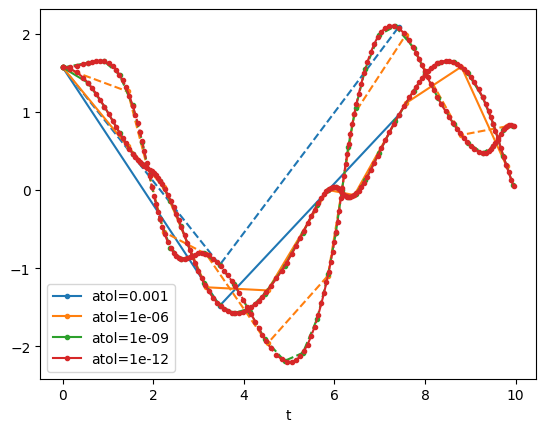

In [27]:
for i, atol in enumerate([1e-3,1e-6,1e-9,1e-12]):
    T, X = DP45(f_dp, np.array([np.pi/2, np.pi/2, 0.0, 0.0]), 0, 10, 0.1, atol, 0)
    plt.plot(T[::10], X[::10,0], '.-',  color=f'C{i}', label=f'atol={atol}')
    plt.plot(T[::10], X[::10,1], '.--', color=f'C{i}')
plt.legend()
plt.xlabel('t')

### Summary

Adaptive time stepping is essential for problems that exhibit rapid, chaotic, or otherwise complex behavior.
By continually adjusting the step size, $\Delta t$, we ensure numerical errors remain under control while avoiding unnecessary computational overhead.
This strategy proves especially beneficial for highly sensitive systems, where even slight changes in time steps can have dramatic effects on the calculated trajectory.

Embedded Runge–Kutta methods, such as the Dormand–Prince (DP) family, are particularly well-suited for adaptive stepping.
They produce multiple estimates of different orders within a single step, with the difference between these estimates serving as a direct measurement of local truncation error.
Error control mechanisms, like the proportional–integral (PI) controller, dynamically adjust the step size based on these estimates, balancing accuracy and efficiency.
To handle a wide range of solution magnitudes, we combine absolute and relative tolerances to form the error threshold.

Although there are methods like Richardson extrapolation that can formally boost the order of accuracy, embedded Runge–Kutta formulas remain the primary choice for practical error estimation.
By default, many established software libraries (including MATLAB's `ode45`) rely on embedded DP methods for their robust performance and favorable trade-off between cost and accuracy.

## Lagrangian Mechanics and the Euler-Lagrange Equation

Classical mechanics can be formulated in multiple ways:
1. Newton's Laws (force-based),
2. Lagrangian Mechanics (action-based),
3. Hamiltonian Mechanics (energy-based).

In this section, we focus on Lagrangian mechanics, a powerful approach that simplifies problem solving.
It is the foundation of many areas of modern physics, from elementary particle physics to general relativity.

### The Principle of Least Action

The idea of an "action principle" can be traced back to the 17th and 18th centuries.
Early forms appeared in the work of Pierre de Fermat on the path taken by light (Fermat's principle of least time) and in Gottfried Wilhelm Leibniz's notions of optimality and geometry.
By the mid-18th century, mathematicians and physicists such as Pierre Louis Maupertuis, Leonhard Euler, and Joseph-Louis Lagrange had generalized these ideas into what is now called the Principle of Least Action (or more accurately, the "Principle of Stationary Action").

The key philosophical shift was recognizing that nature can often be described as if it "chooses" a path or configuration that makes some quantity---called the action---stationary (usually a minimum, but more precisely an extremum) with respect to small variations of the trajectory.
This viewpoint was revolutionary because it reframed the laws of motion away from cause-and-effect forces (Newton's laws) and toward an elegant variational principle.

Veritasium has an amazing video on the [principle of action](https://youtu.be/Q10_srZ-pbs) that covers both historical and mathematical/physical significance of it.

We denote the action $S$ of a mechanical system moving between times $t_1$ and $t_2$ as an integral over a function called the Lagrangian $L$:
\begin{align}
S[\mathbf{q}] = \int_{t_1}^{t_2} L\left(\mathbf{q}(t), \dot{\mathbf{q}}(t), t\right)dt,
\end{align}
where:
* $\mathbf{q}(t)$ represents the generalized coordinates of the system (e.g., angles, positions in space, etc.).
* $\dot{\mathbf{q}}(t) = \frac{d}{dt}\mathbf{q}(t)$ denotes the time derivatives of these coordinates.
* $L(\mathbf{q}, \dot{\mathbf{q}}, t)$ is often written as $T - V$, the kinetic energy $T$ minus the potential energy $V$, for many standard physical systems.

This integral of the Lagrangian over time is a single scalar number that characterizes the entire path $\mathbf{q}(t)$ taken by the system between $t_1$ and $t_2$.

Hamilton's Principle (or the Principle of Least Action) states that the actual trajectory $\mathbf{q}(t)$ followed by a physical system makes the action $S[\mathbf{q}]$ stationary with respect to small variations of the path.
Symbolically, if we perturb the coordinates by a tiny amount $\delta\mathbf{q}(t)$, the first-order change in the action $\delta S$ must vanish:
\begin{align}
\delta S = \delta \int_{t_1}^{t_2} L(\mathbf{q}, \dot{\mathbf{q}}, t) dt = 0.
\end{align}
It is important to note that "stationary" means the action could be a minimum, a maximum, or even a saddle point in function space.
Nevertheless, it is historically called the "Principle of Least Action," reflecting many common systems in which the solution does indeed minimize $S$.
The rigorous requirement is that the action cannot be lowered by an infinitesimal variation of the physical path, which is what $\delta S = 0$ encodes.

### The Euler-Lagrange Equation

The Euler-Lagrange equation is the probably the most important result of Lagrangian mechanics.
It directly follows from the Principle of Least Action.
Once derived, it provides a systematic way to obtain the equations of motion in generalized coordinates.

We write:
\begin{align}
\delta S = \delta \int_{t_1}^{t_2} L\left(q,\dot{q},t\right) dt.
\end{align}

Because $S$ is an integral, we can bring the variation inside:
\begin{align}
\delta S = \int_{t_1}^{t_2} \delta L\left(q,\dot{q},t\right) dt.
\end{align}

Next, we expand the variation $\delta L$ in terms of $\delta q$ and $\delta \dot{q}$:
\begin{align}
\delta L
= \frac{\partial L}{\partial q} \delta q
+ \frac{\partial L}{\partial \dot{q}} \delta\dot{q}
+ \frac{\partial L}{\partial t} \delta t.
\end{align}

Since $t$ is our independent variable and is not itself being varied, the last term is typically omitted.
Thus:
\begin{align}
\delta S = \int_{t_1}^{t_2} \left(
  \frac{\partial L}{\partial q}\,\delta q
+ \frac{\partial L}{\partial \dot{q}}\,\delta \dot{q}
\right) dt.
\end{align}

The term $(\partial L/\partial \dot{q})\delta \dot{q}$ can be converted into a function of $\delta q$ by using integration by parts.
In one dimension:
\begin{align}
\int_{t_1}^{t_2} \frac{\partial L}{\partial \dot{q}}\,\delta \dot{q}\,dt
= \left[\frac{\partial L}{\partial \dot{q}} \delta q \right]_{t_1}^{t_2}
- \int_{t_1}^{t_2} \frac{d}{dt}\Bigl(\frac{\partial L}{\partial \dot{q}}\Bigr)\delta q dt.
\end{align}

Since $\delta q(t_1) = \delta q(t_2) = 0$ by the boundary conditions, the boundary term
\begin{align}
\left[\frac{\partial L}{\partial \dot{q}}\,\delta q\right]_{t_1}^{t_2}.
\end{align}
vanishes.

Thus, the variation of the action becomes:
\begin{align}
\delta S 
&= \int_{t_1}^{t_2} \left[
\frac{\partial L}{\partial q} -
\frac{d}{dt}\Bigl(\frac{\partial L}{\partial \dot{q}}\Bigr)\right] \delta q\,dt.
\end{align}

The principle of stationary action states $\delta S = 0$ for all permissible $\delta q(t)$.
Since $\delta q(t)$ is an arbitrary small variation (other than being zero at the endpoints), the only way for the integral $\delta S = 0$ to hold for every possible $\delta q(t)$ is for the integrand itself to vanish identically:
\begin{align}
\frac{\partial L}{\partial q} - \frac{d}{dt}\Bigl(\frac{\partial L}{\partial \dot{q}}\Bigr) = 0.
\end{align}
This is the Euler-Lagrange equation for the single coordinate $q$.

# Computational Lagrangian Mechanics

Having the Euler–Lagrange equation allows us to write down the equations of motion for any system given its Lagrangian.
Based on what we've learned from this class, we convert each second-order Euler–Lagrange equation into two first-order ODEs in time (for $q_i$ and $\dot{q}_i$).
These can then be integrated with standard ODE solvers (e.g., Runge–Kutta and PD45 methods).
Here, we will see how to automate the derivation of these equations using automatic differentiation (autodiff) and then solve them numerically.

To cast the Euler-Lagrange equation into a form that we can use with an ODE integrator, let $x = q$ and $v = \dot{q}$.
The Euler-Lagrange equation becomes:
\begin{align}
  \frac{d}{dt}\left(\frac{\partial L}{\partial v}\right) &= \frac{\partial L}{\partial q} \\
  \frac{\partial^2 L}{\partial v^2} \dot{v} + \frac{\partial^2 L}{\partial x\partial v} \dot{x} &= \frac{\partial L}{\partial q} \\
\end{align}
Let $a = \dot{v}$ and rearrange,
\begin{align}
  \frac{\partial^2 L}{\partial v^2} a &= \frac{\partial L}{\partial q} - \frac{\partial^2 L}{\partial x\partial v} v \\
  a &= \left(\frac{\partial^2 L}{\partial v^2}\right)^{-1} \left(\frac{\partial L}{\partial q} - \frac{\partial^2 L}{\partial x\partial v} v\right)
\end{align}
This last equation is exactly what we can put into an ODE integrator.

In [28]:
from jax import grad, jacfwd, jit
from jax.numpy.linalg import inv

def ELrhs(L):
    
    Lx  = grad(L, argnums=0)
    Lv  = grad(L, argnums=1)
    Lvp = jacfwd(Lv, argnums=(0,1))

    @jit
    def rhs(xv):
        x,   v   = xv
        Lvx, Lvv = Lvp(x, v)
        a = inv(Lvv) @ (Lx(x, v) - v @ Lvx)
        return np.array([v, a])

    return rhs

In [29]:
def path(L, xv0, t0, t1, dt=0.1, atol=1e-6, rtol=1e-6):
    return DP45(ELrhs(L), xv0, t0, t1, dt, atol, rtol)

### Example Applications

We can now apply `path()` to solve a multi-dimensional simple harmonic oscillator:

In [30]:
def L(x, v):
    return np.sum(0.5 * v * v - 0.5 * x * x)

In [31]:
xv0   = np.array([[0.0,1.0], [1.0,0.0]])
T, XV = path(L, xv0, 0.0, 2 * np.pi)

X = XV[:,0,:]
V = XV[:,1,:]

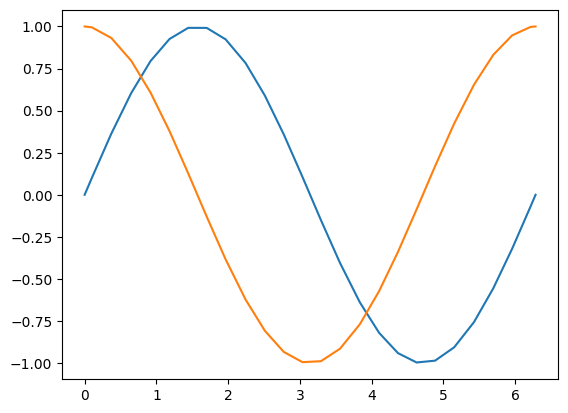

In [32]:
plt.plot(T, X)

### Summary

We started with the Lagrangian viewpoint of classical mechanics, where each system is described by its kinetic and potential energies.
Instead of directly applying Newton's laws, we use the principle of least action to determine how a system evolves in time.
This approach not only simplifies the treatment of constraints and complex coordinate systems but also unifies a wide range of physical problems under a single conceptual framework.

The next step involved translating our Lagrangian-based description into a concrete numerical procedure.
Perhaps the most exciting part of our workflow is the use of automatic differentiation (autodiff).
Rather than manually computing partial derivatives, we let autodiff tools do the heavy lifting.
By defining the Lagrangian in code, we automatically generate the required derivatives and then form the corresponding equations of motion on the fly.
This reduces the overhead of dealing with algebraic details, freeing us to focus on modeling and exploration.

Finally, we combined these pieces into a Computational Lagrangian Mechanics solver.
To the best of my knowledge, this streamlined toolchain is not found in standard Python libraries.
This showcases how creatively leveraging existing numerical methods can push us to the cutting edge of computational physics!